In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator             #ImageDataGenerator generates batches of tensor image data with real-time data augmentation or to expand the size of the dataset
from tensorflow.keras.applications import MobileNetV2                           #MobileNetV2 is a very effective feature extractor for object detection and segmentation
from tensorflow.keras.layers import AveragePooling2D                            #Pooling Layer(average will be taken into consideration and a 2d matrix is taken as filter)
from tensorflow.keras.layers import Dropout                                     #To Prevent Neural Networks from Overfitting
from tensorflow.keras.layers import Flatten                                     #Flattening the matrix Eg. From 2D -> 1D
from tensorflow.keras.layers import Dense                                       #Connected Neural Network
from tensorflow.keras.layers import Input                                       #Input() is used to instantiate a Keras tensor.
from tensorflow.keras.models import Model                                       #Model groups layers into an object with training and inference features.
from tensorflow.keras.optimizers import Adam                                    #activation function
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input         #Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.preprocessing.image import img_to_array                   #convert image to array
from tensorflow.keras.preprocessing.image import load_img                       #used to load image 
from tensorflow.keras.utils import to_categorical                               #Converts a class vector (integers) to binary class matrix
from sklearn.preprocessing import LabelBinarizer                                #sklearn.preprocessing.Binarizer() is a method which belongs to preprocessing module. It plays a key role in the discretization of continuous feature values. link-https://www.geeksforgeeks.org/sklearn-binarizer-in-python/ 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths                                                       #
import matplotlib.pyplot as plt
import numpy as np
import os                                                                       #

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20                                                                     #An epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed
BS = 32

In [ ]:
DIRECTORY = r"/content/drive/MyDrive/dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")


In [ ]:
data = []
labels = []

In [ ]:
!pip install -r requirements.txt

In [ ]:

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)                                    #os.path.join() method in Python join one or more path components intelligently
    for img in os.listdir(path):                                                #This method returns the list of all files and directories in the specified path. The return type of this method is list.
    	img_path = os.path.join(path, img)                                        
    	image = load_img(img_path, target_size=(224, 224))                        #
    	image = img_to_array(image)
    	image = preprocess_input(image)                                           #

    	data.append(image)
    	labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer() 
labels = lb.fit_transform(labels)                                               
#fit_transform() is used on the training data so that we can scale the training data and also learn the scaling parameters of that data
labels = to_categorical(labels)
#to_categorical() method is used to one-hot encode integer data.

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,                 #splitting train and test set
	test_size=0.20, stratify=labels, random_state=42)                             #The 'stratify' parameter comes into handy so that the proportion of values in the sample produced in our test group will be the same as the proportion of values provided to parameter stratify

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:                                                  #What does freezing a model mean?
#Freezing the model means producing a singular file containing information about the graph and checkpoint variables, but saving these hyperparameters as constants within the graph structure
	layer.trainable = False

https://keras.io/api/optimizers/adam/

 it's very useful to Adam with learning rate decay. Without decay, you have to set a very small learning rate so the loss won't begin to diverge after decrease to a point

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)                                  
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 137s 1s/step - loss: 0.3953 - accuracy: 0.8672 - val_loss: 0.1631 - val_accuracy: 0.9739
Epoch 2/20
95/95 [==============================] - 132s 1s/step - loss: 0.1459 - accuracy: 0.9713 - val_loss: 0.0842 - val_accuracy: 0.9831
Epoch 3/20
95/95 [==============================] - 131s 1s/step - loss: 0.0905 - accuracy: 0.9786 - val_loss: 0.0612 - val_accuracy: 0.9857
Epoch 4/20
95/95 [==============================] - 131s 1s/step - loss: 0.0736 - accuracy: 0.9782 - val_loss: 0.0517 - val_accuracy: 0.9870
Epoch 5/20
95/95 [==============================] - 131s 1s/step - loss: 0.0624 - accuracy: 0.9825 - val_loss: 0.0441 - val_accuracy: 0.9857
Epoch 6/20
95/95 [==============================] - 132s 1s/step - loss: 0.0585 - accuracy: 0.9825 - val_loss: 0.0407 - val_accuracy: 0.9870
Epoch 7/20
95/95 [==============================] - 131s 1s/step - loss: 0.0493 - accuracy: 0.9855 - val_loss: 0.0369 - val_accura

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [ ]:

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


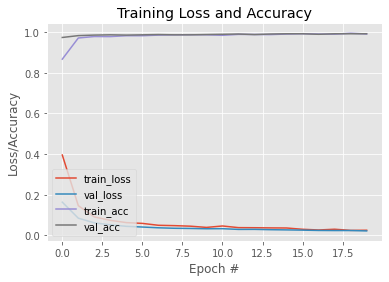

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")